## **Introduction to Image Processing**

Mojdeh Rastgoo - Desire Sidibe

## 3. Interpolation and Blending

 Importing necessary libraries/modules and functions

In [77]:
% matplotlib inline
% pprint off


# Import the library as show images, plot, etc.
import matplotlib.pyplot as plt
# Import functionality for the color map
import matplotlib.cm as cm

# Import system specific parameters and function
import sys 

## Other plotting libraries
# import seaborn as sns

# Import the library to mange the matrix and array 
import numpy as np

# Importing image processing toolbox 
## Module to read, write,... 
from skimage import io
## Module to convert the image on 8 bits
from skimage import img_as_ubyte
from skimage import img_as_uint
## Module to convert the image to float
from skimage import img_as_float
## Module for color conversion 
from skimage import color
## Module image transform from skimage for resize 
from skimage import transform
## Module misc from scipy for resize 
from scipy import misc
## Module util from skimage 
from skimage import exposure as exp

from PIL import Image

Pretty printing has been turned ON


### 3.1  Resizing an image size using different interpolation functions

** Q.1 Resize the `lena` or `vibot` image using nearest, bilinear and bicubic function.** 

You can define your function which accept the model and resize size from the user or just run a script.

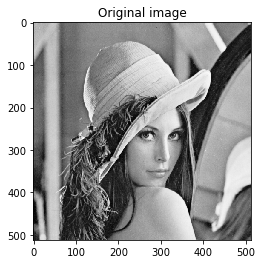

In [3]:
path = './images/'
img_names = ['apple.jpeg', 'lena-grey.bmp', 'orange.jpeg', 'vibot-color.jpg']

img_lena = io.imread(path + img_names[1])
plt.imshow(img_lena, cmap = cm.Greys_r)
plt.title('Original image')
plt.show()

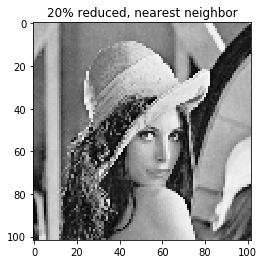

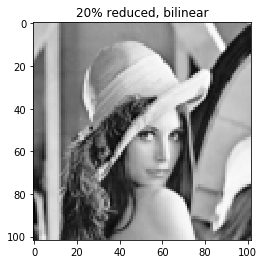

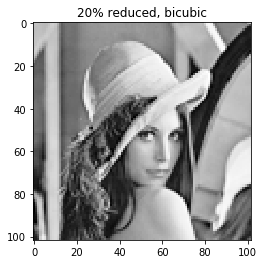

In [3]:
#interp : ‘nearest’, ‘lanczos’, ‘bilinear’, ‘bicubic’ or ‘cubic’
img_lena_20 = misc.imresize(img_lena, 20, interp = 'nearest')
plt.imshow(img_lena_20, cmap = cm.Greys_r)
plt.title('20% reduced, nearest neighbor')
plt.show()

img_lena_20 = misc.imresize(img_lena, 20, interp = 'bilinear')
plt.imshow(img_lena_20, cmap = cm.Greys_r)
plt.title('20% reduced, bilinear')
plt.show()

img_lena_20 = misc.imresize(img_lena, 20, interp = 'bicubic')
plt.imshow(img_lena_20, cmap = cm.Greys_r)
plt.title('20% reduced, bicubic')
plt.show()

**Q.2 Write three functions that performs `simple_blend`, `alpha_blend` and `pyramid_blend`**

** Using your functions, blend `orange` and `apple` images together.**


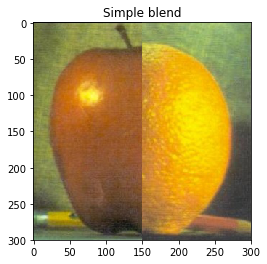

In [4]:
img_apl = io.imread(path + img_names[0])
img_org = io.imread(path + img_names[2])

def simple_blend(img1, img2):
    shape1 = img1.shape
    shape2 = img2.shape
    
    img_out = np.array(img1)
    
    if (shape1 == shape2):
        for i in range(0, shape1[0]):
            for j in range(shape1[1]//2, shape1[1]):
                    img_out[i, j] = img2[i, j, :]
    else: 
        raise('Not implemented')    
        
    return img_out    
    
blend_s = simple_blend(img_apl, img_org)
plt.imshow(blend_s)
plt.title('Simple blend')

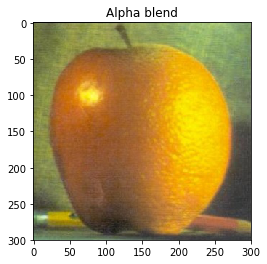

In [5]:
def alpha_blend(img1, img2, window = 0):
    shape1 = img1.shape
    shape2 = img2.shape
    
    img_out = np.array(img1)
    
    if (shape1 == shape2):
        for i in range(0, shape1[0]):
            #we should add window transition function, you implementes alpha incorrectly, should be 50:50
            trans_coord = round(0.5* shape1[1])
            
            for j in range(trans_coord - window//2, trans_coord + window//2):
                img_out[i, j] = ((- j + trans_coord + window//2)/ window) * img1[i, j, :] +\
                ((j - trans_coord + window//2)/ window)*img2[i, j, :]
            
            for j in range(trans_coord + window//2, shape1[1]):
                img_out[i, j] = img2[i, j, :]
    else: 
        raise('Not implemented')    
        
    return img_out

blend_s = alpha_blend(img_apl, img_org, window = 100)
plt.imshow(blend_s)
plt.title('Alpha blend')

In [82]:
def add_pyramids(pyr1, pyr2, pyr_mask):
    """Function adds two input laplasian pyramids using specified mask pyramid
    
    Args:
        pyr1: lapsian pyramid of the first grey image, in case of rgb image this will be one layer only,
        example red layer
        pyr2: lapsian pyramid of the second grey image
        mask: gaussian pyramid of the mask
          
    Returns:
        out: resulting pyramid
    """
    out = []
        
    for p1, p2, m_rgb in zip(pyr1, pyr2, pyr_mask):
        m = m_rgb[:, :]
        
        if (len(out) == 0):
            out.append(np.multiply(m, p1) + np.multiply((1 - m), p2))
        else:
            out.append(np.multiply(m, p1) + np.multiply((1 - m), p2))
            
    return out


def pyramid_collapse(lapl_pyr):
    """Function collapse input laplasian pyramid into output image
    Args:
        lapl_pyr: reversed laplasian pyramid to be collapsed, should start from the smallest element
    Returns:
        np.array: output image
    """
    img_out = None 
    
    for index, p_r in enumerate(lapl_pyr):
        if (index == 0):
            img_out = p_r
        else:
            img_out = p_r + transform.resize(img_out, p_r.shape, mode = "constant")
            
    return img_out


def pyramid_blend_grey(img1, img2):
    """Blends two grey images of the same size using laplasin pyramids of them
    
    Args:
        img1: input grey image
        img2: input grey image
        
    Returns:
        img_out: output blended image
    """
    
    if ((len(img1.shape) == 3) or (len(img2.shape) == 3)):
        raise(ValueError("pyramid_blend_grey blends only grey images"));
        
    #We assume that the images are of the same size
    rows, cols = img1.shape
    
    pyr_img1 = reversed(tuple(transform.pyramid_laplacian(img1[:, :])))
    pyr_img2 = reversed(tuple(transform.pyramid_laplacian(img2[:, :])))
    
    #mask definition
    mask = np.zeros(img1.shape)
    mask[:, : int(np.ceil(cols / 2))] = 1.0
    mask[:, int(np.ceil(cols / 2)) :] = 0.0
    
    pyr_mask = tuple(reversed(tuple(transform.pyramid_gaussian(mask))))
    
    pyr_out = add_pyramids(pyr_img1, pyr_img2, pyr_mask)
    img_out = pyramid_collapse(pyr_out)
    
    return img_out

    
def pyramid_blend_rgb(img1, img2):
    """Blends two rgb images using laplasian pyramids of them
        
    Args:
        img1: input rgb image
        img2: input rgb image
        
    Returns:
        img_out: output blended image
    """
    img1 = img_as_float(img1)
    img2 = img_as_float(img2)
    #We assume that the images are of the same size only
    rows, cols, levels = img1.shape
    
    #red
    img_out_r = pyramid_blend_grey(img1[:, :, 0], img2[:, :, 0])
        
    #green
    img_out_g = pyramid_blend_grey(img1[:, :, 1], img2[:, :, 1])
            
    #blue
    img_out_b = pyramid_blend_grey(img1[:, :, 2], img2[:, :, 2])
    
    #creting rbg image
    img_out = np.zeros((rows, cols, levels), np.float64)
    
    for row in range(rows):
        for col in range(cols):
            img_out[row, col, 0] = img_out_r[row, col]
            img_out[row, col, 1] = img_out_g[row, col]
            img_out[row, col, 2] = img_out_b[row, col]

    return img_as_ubyte(img_out)

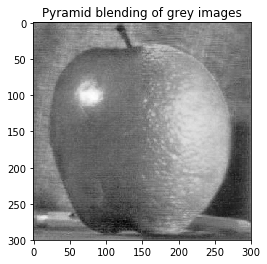

/home/okozyn/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


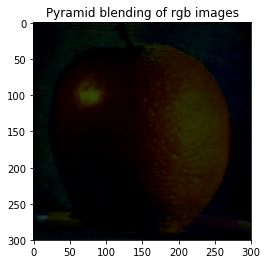

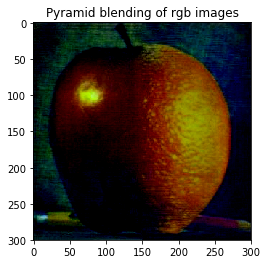

In [84]:
#usage sample
img_apl_grey = color.rgb2grey(img_apl)
img_org_grey = color.rgb2grey(img_org)

img_ao_grey = pyramid_blend_grey(img_apl_grey, img_org_grey)
plt.imshow(img_ao_grey, cmap = cm.Greys_r)
plt.title("Pyramid blending of grey images")
plt.show()

img_ao = pyramid_blend_rgb(img_apl, img_org)  
plt.imshow(img_ao)
plt.title("Pyramid blending of rgb images")
plt.show()

plt.imshow(exp.rescale_intensity(img_ao))
plt.title("Pyramid blending of rgb images")
plt.show()